In [1]:
!pip -q install evaluate peft

In [2]:
from transformers import pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from datasets import Dataset, DatasetDict
import evaluate
import os
import torch

pd.set_option('display.max_colwidth', None)
os.environ["WANDB_DISABLED"] = "true"

2024-08-06 12:52:29.814864: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-06 12:52:29.814967: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-06 12:52:29.990047: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_name = "facebook/roberta-hate-speech-dynabench-r4-target"
pipe = pipeline("text-classification", model=model_name, device=device)

config.json:   0%|          | 0.00/816 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [8]:
dfRaw = pd.read_csv('/kaggle/input/hate-speech-and-offensive-language-dataset/labeled_data.csv')

In [9]:
dfRaw.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;


In [10]:
print('hate_speech value distribution', dfRaw.offensive_language.value_counts())

hate_speech value distribution offensive_language
3    13383
2     4246
0     3475
1     2066
6      857
5      369
4      251
9       66
8       37
7       33
Name: count, dtype: int64


In [11]:
df = dfRaw[((dfRaw['hate_speech'] >= 2) & (dfRaw['class'] == 0)) | ((dfRaw['neither'] >= 2) & (dfRaw['class'] == 2))]
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
40,40,3,0,1,2,2,""" momma said no pussy cats inside my doghouse """
63,63,3,0,0,3,2,"""@Addicted2Guys: -SimplyAddictedToGuys http://t.co/1jL4hi8ZMF"" woof woof hot scally lad"
66,66,3,0,1,2,2,"""@AllAboutManFeet: http://t.co/3gzUpfuMev"" woof woof and hot soles"
67,67,3,0,1,2,2,"""@Allyhaaaaa: Lemmie eat a Oreo &amp; do these dishes."" One oreo? Lol"


In [12]:
df.insert(1, 'hate', 0)
df.loc[df['hate_speech'] >= 2, 'hate'] = 1
df = df[['hate', 'tweet']]
df.head()

,hate,tweet
0,0,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
40,0,""" momma said no pussy cats inside my doghouse """
63,0,"""@Addicted2Guys: -SimplyAddictedToGuys http://t.co/1jL4hi8ZMF"" woof woof hot scally lad"
66,0,"""@AllAboutManFeet: http://t.co/3gzUpfuMev"" woof woof and hot soles"
67,0,"""@Allyhaaaaa: Lemmie eat a Oreo &amp; do these dishes."" One oreo? Lol"


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5593 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   hate    5593 non-null   int64 
 1   tweet   5593 non-null   object
dtypes: int64(1), object(1)
memory usage: 131.1+ KB


In [14]:
df.hate.value_counts()

hate
0    4154
1    1439
Name: count, dtype: int64

In [15]:
tweets = df.iloc[:3]['tweet'].tolist()
outs = pipe(tweets)
# print(tweets)
print(outs)
print([out['label'] == 'hate' for out in outs])

[{'label': 'nothate', 'score': 0.9589850902557373}, {'label': 'nothate', 'score': 0.9989342093467712}, {'label': 'hate', 'score': 0.7065165638923645}]
[False, False, True]


In [17]:
# df.loc[df['hate'] == 1].head()

In [18]:
n_samples = 1000
sampleDf = df.iloc[:n_samples]
preds = pipe(df.tweet.tolist()[:n_samples])
sampleDf.insert(1, 'predictions_hate', [int(pred['label'] == 'hate') for pred in preds])
sampleDf

,hate,predictions_hate,tweet
0,0,0,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
40,0,0,""" momma said no pussy cats inside my doghouse """
63,0,1,"""@Addicted2Guys: -SimplyAddictedToGuys http://t.co/1jL4hi8ZMF"" woof woof hot scally lad"
66,0,0,"""@AllAboutManFeet: http://t.co/3gzUpfuMev"" woof woof and hot soles"
67,0,0,"""@Allyhaaaaa: Lemmie eat a Oreo &amp; do these dishes."" One oreo? Lol"
...,...,...,...
4222,0,0,@NTXProgressive Yeah..cause if anyone thinks this clown went to @target to buy Oreos is as stupid as all of them look
4223,0,0,"@NYDNSports @Yankees ugh , @Espo4710 put one 420 dead center off him @StFrancisNews"
4224,0,1,@NYRKelsMads \nDat damn dog eats betta den most colored folk do.
4226,0,0,@NYRKelsMads \nI be wishin you was local. I takes you to da Yankee game and spoil you


Overall Accuracy: 88.50%


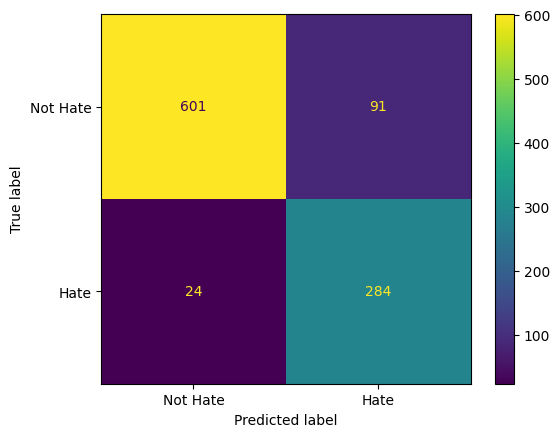

In [19]:
accuracy = len(sampleDf[sampleDf['hate'] == sampleDf['predictions_hate']]) / len(sampleDf)
print(f"Overall Accuracy: {accuracy * 100:.2f}%")

cm = confusion_matrix(sampleDf['hate'], sampleDf['predictions_hate'], labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Not Hate', 'Hate'])
disp.plot()
plt.show()


In [20]:
dfTrain = df.rename(columns={
    'tweet': 'text',
    'hate': 'label'
})
dfTrain.head()

,label,text
0,0,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
40,0,""" momma said no pussy cats inside my doghouse """
63,0,"""@Addicted2Guys: -SimplyAddictedToGuys http://t.co/1jL4hi8ZMF"" woof woof hot scally lad"
66,0,"""@AllAboutManFeet: http://t.co/3gzUpfuMev"" woof woof and hot soles"
67,0,"""@Allyhaaaaa: Lemmie eat a Oreo &amp; do these dishes."" One oreo? Lol"


In [21]:
indexTrain = round(0.8*len(dfTrain))
indexVal = round(0.9*len(dfTrain))
indexTest = len(dfTrain)
train = dfTrain.iloc[:indexTrain]
val = dfTrain.iloc[indexTrain:indexVal]
test = dfTrain.iloc[indexVal:]

In [22]:
print(len(train), len(val), len(test))

4474 560 559


In [23]:
dataset = DatasetDict()
dataset['train'] = Dataset.from_pandas(train)
dataset['val'] = Dataset.from_pandas(val)
dataset['test'] = Dataset.from_pandas(test)
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text', '__index_level_0__'],
        num_rows: 4474
    })
    val: Dataset({
        features: ['label', 'text', '__index_level_0__'],
        num_rows: 560
    })
    test: Dataset({
        features: ['label', 'text', '__index_level_0__'],
        num_rows: 559
    })
})

Overall Accuracy: 92.13%


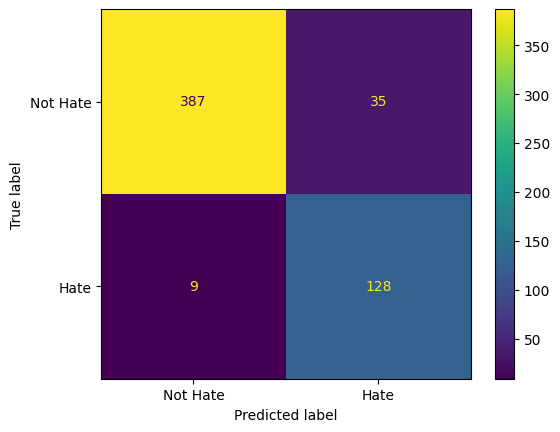

In [24]:
sampleDf = test
preds = pipe(test.text.tolist()[:n_samples])
sampleDf.insert(1, 'predictions_hate', [int(pred['label'] == 'hate') for pred in preds])

sampleDf

accuracy = len(sampleDf[sampleDf['label'] == sampleDf['predictions_hate']]) / len(sampleDf)
print(f"Overall Accuracy: {accuracy * 100:.2f}%")

cm = confusion_matrix(sampleDf['label'], sampleDf['predictions_hate'], labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Not Hate', 'Hate'])
disp.plot()
plt.show()

In [25]:
from transformers import AutoTokenizer, DataCollatorWithPadding

tokenizer = AutoTokenizer.from_pretrained(model_name)


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/4474 [00:00<?, ? examples/s]

Map:   0%|          | 0/560 [00:00<?, ? examples/s]

Map:   0%|          | 0/559 [00:00<?, ? examples/s]

In [26]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [27]:
id2label = {0: "hate", 1: "not hate"}
label2id = {"hate": 0, "not hate": 1}

In [28]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=2, id2label=id2label, label2id=label2id).to(device)

In [29]:
from transformers import TrainingArguments, Trainer

In [30]:
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    r=32, # Rank
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_CLS)


In [31]:
output_dir = f'/kaggle/working/peft-training'
batch_size = 1

peft_model = get_peft_model(model, 
                            lora_config)

peft_training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=1e-3,
    max_steps = 1,
    logging_steps=1,
    load_best_model_at_end=True,
    evaluation_strategy='steps',
    save_strategy='steps'
)
    
peft_trainer = Trainer(
    model=peft_model,
    args=peft_training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["val"],
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
max_steps is given, it will override any value given in num_train_epochs


In [32]:
peft_trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss
1,0.098400,0.437003


TrainOutput(global_step=1, training_loss=0.09836827218532562, metrics={'train_runtime': 26.3503, 'train_samples_per_second': 0.076, 'train_steps_per_second': 0.038, 'total_flos': 537107914752.0, 'train_loss': 0.09836827218532562, 'epoch': 0.0004470272686633885})

In [33]:
peft_model.eval()
pred = test.copy()
preds = []
for text in test['text']:
    inputs = tokenizer([text], return_tensors="pt", padding=True)
    logits = peft_model(input_ids=inputs["input_ids"].to(device)).logits
    hate = int(logits.softmax(dim=-1).tolist()[0][1] > 0.7)
    preds.append(hate)
    
pred.insert(1, 'pred', preds)
pred.head()

,label,pred,predictions_hate,text
22027,0,0,0,This cowboys an redskins game was a hell of a game
22028,0,0,0,"This does create a slippery slope tho , players gonna have to watch they mouth too , no tolerance for ignorance anymore"
22030,0,0,0,This dumb Berk drives in circles through town on his bright yellow cycle with music blaring incredibly&#8230; http://t.co/ukothl3MOH
22036,0,0,0,This flappy bird game addicting .
22040,0,0,0,This fuzzy wuzzy kitten wants to know how a raven is like a writing desk. Find out why here &#8594; http://t.co/GI9On86iGV http://t.co/HlKDTSgKwU


In [34]:
pred['pred'].value_counts()

pred
0    415
1    144
Name: count, dtype: int64

Overall Accuracy: 93.74%


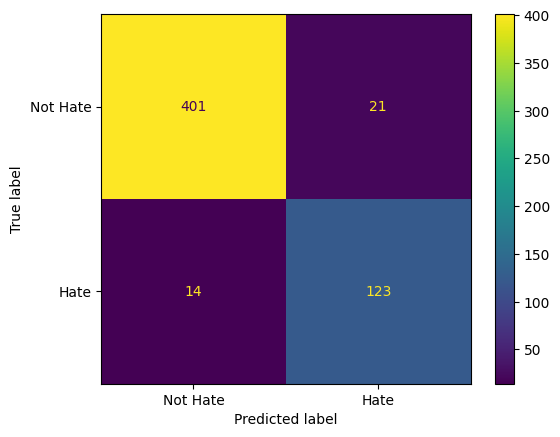

In [35]:
accuracy_after = len(pred[pred['label'] == pred['pred']]) / len(pred)
print(f"Overall Accuracy: {accuracy_after * 100:.2f}%")

cm = confusion_matrix(pred['label'], pred['pred'], labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Not Hate', 'Hate'])
disp.plot()
plt.show()

In [36]:
improvement = accuracy_after - accuracy
print(f"Accuracy Improvement: {improvement * 100:.2f}%")

Accuracy Improvement: 1.61%
